Results for the first 40 epochs

In [1]:
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
import torch
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() == True else 'cpu'

In [3]:
device

'cuda'

In [5]:
import numpy as np

def new_data2(file,lines):
  d = {}
  ind2w = {0: "SOS", 1: "EOS"}
  lets = 2
  f  = open(file)
  mass = []
  mws = [] # molec weigths
  forms = [] # molec form
  types_ = [] # types nan, MS1, MS2 : 0, 1, 2
  mspec = []
  smi = []
  c = 0
  l = 0
  for line in f:
    l +=1
    if len(line.split()) != 2:
        c = 1
    else:
        c = 0
    if c == 1:
      smi.append(line.split(',')[0])
      mws.append(float(line.split(',')[-1]))
 
      forms.append(np.array([int(ii) for ii in line.split(',')[4:10]]))
    #  forms.append([line.split(',')[4:10]])
      if line.split(',')[1] == 'nan':
        types_.append(0)
      else:
        if line.split(',')[1] == 'MS1':
          types_.append(1)
        elif line.split(',')[1] == 'MS2':
          types_.append(2)

      for letter in line.split(',')[0]:
        if letter not in d:
          d[letter] = int(lets)
          ind2w[lets] = letter
          lets += 1
    if c == 0:
        mspec.append((float(line.split()[0]),float(line.split()[1])))
    if c == 1 or l == lines:
      mass.append(mspec)
      mspec = []

  return np.array(mass), np.array(mws), np.array(forms),np.array(types_), np.array(smi), d, ind2w

In [7]:
f = 'path_to_file'
num_lines = sum(1 for line in open(f))
num_lines


4992568

In [8]:
x,x2,x3,x4,y,dic,ind2w = new_data2(f,num_lines)

In [9]:
len(y),len(x),len(x2),len(x3),len(x4)

(33038, 33039, 33038, 33038, 33038)

In [10]:
x = np.delete(x,0)


In [11]:
len(x),len(x2),len(x3),len(y)

(33038, 33038, 33038, 33038)

In [12]:
#REMOVE OUTLIER; MOLECULES WITH MASS WEIGHT > 100
maxw=300

for wei in reversed(x2):
 # print('wwwee',wei)
  if wei > maxw:
    idx = np.where(x2 == wei)

#    print(y[idx],len(y[idx]),'index',idx)
  #
    y = np.delete(y,idx)
    x = np.delete(x,idx)
    x2 = np.delete(x2,idx)
    x3 = np.delete(x3,idx,axis=0)
    x4 = np.delete(x4,idx)


In [13]:
len(y),len(x),len(x2),len(x3),len(x4)

(11871, 11871, 11871, 11871, 11871)

max len 49


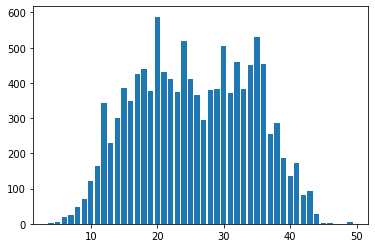

In [14]:
import matplotlib.pyplot as plt
lens={}
ml = 0
for smi in y:
  if len(smi) > ml:
    ml = len(smi)
  else:
    ml = ml
  if len(smi) not in lens:
    lens[len(smi)] = 1
  else:
    lens[len(smi)] += 1
plt.bar(lens.keys(),lens.values())
print('max len', ml)

In [15]:
## CHECK RANDOM
x[1333],x2[1333],x3[1333],x4[1333],y[1333]

([(41.00806, 0.113504),
  (45.85474, 0.112828),
  (45.99456, 23.002034),
  (46.18894, 0.112828),
  (46.21088, 0.112828),
  (46.2481, 0.085128),
  (46.27292, 0.141204),
  (46.29392, 0.085128),
  (46.38277, 0.113504),
  (91.01894, 0.056752),
  (92.02596, 11.934762),
  (92.0677, 0.056752),
  (107.69119, 0.717505),
  (108.02353, 100.0),
  (108.18113, 0.141204),
  (108.31255, 0.18039),
  (108.36368, 0.245924),
  (108.38852, 0.289839),
  (108.42213, 0.245924),
  (108.4499, 0.36213),
  (108.49375, 0.461446),
  (108.50983, 0.183768),
  (108.53615, 0.220251),
  (108.561, 0.14796),
  (108.61805, 0.149987),
  (108.64438, 0.2189),
  (108.70876, 0.145258),
  (108.73363, 0.14796),
  (108.76291, 0.140528),
  (108.76876, 0.148636),
  (108.79803, 0.308081),
  (108.85661, 0.112828),
  (109.03093, 0.141204),
  (109.19366, 0.056752),
  (122.01872, 0.056752),
  (137.59944, 0.252681),
  (138.02452, 54.038497),
  (138.05255, 0.096613),
  (138.20432, 0.085128)],
 139.02694301999998,
 array([6, 5, 3, 1, 0, 0])

In [16]:
X_train1, X_val1,X_train2,X_val2,X_train3,X_val3,X_train4,X_val4,y_train,y_val = train_test_split(x,x2,x3,x4,y,test_size=0.1,random_state=42,shuffle=True) # 




In [17]:
len(X_train1),len(X_val1)

(10683, 1188)

In [18]:
import math
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Encoder as Set transformer classes based from juho lee https://arxiv.org/pdf/1810.00825.pdf

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(X, X)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln)

    def forward(self, X):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB(dim, dim, dim, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X)



class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds, dim_hidden, num_heads, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X))


#Decoder part


class DecoderRNN(nn.Module):
        def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dp, max_length=ml):
                super(DecoderRNN, self).__init__()
                self.embed = nn.Embedding(vocab_size, embed_size)
                #self.lstm = nn.LSTM(embed_size, hidden_size*2, num_layers, batch_first=True, dropout=dp)
                self.lstm = nn.LSTM(embed_size, hidden_size+8, num_layers, batch_first=True, dropout=dp)

             #   self.out = nn.Linear(hidden_size*2, vocab_size)
                self.out = nn.Linear(hidden_size+8, vocab_size)

                self.softmax = nn.LogSoftmax(dim=1)

        def forward(self, in_smiles ,hidden,cell):#
                embeddings = self.embed(in_smiles).view(1,1,-1)
                embeddings = F.relu(embeddings)
                output,(hidden, cell) = self.lstm(embeddings,(hidden,cell))
                outputs = self.softmax(self.out(output[0]))
                return outputs, hidden, cell



In [19]:
tf = 0.75
VOC = len(ind2w)
VOC, ind2w

(30,
 {0: 'SOS',
  1: 'EOS',
  2: 'O',
  3: '=',
  4: 'C',
  5: 'c',
  6: '6',
  7: ')',
  8: '5',
  9: 'N',
  10: 'n',
  11: 'o',
  12: '9',
  13: '%',
  14: '1',
  15: '0',
  16: '[',
  17: 'H',
  18: ']',
  19: 'P',
  20: 's',
  21: '+',
  22: '-',
  23: 'S',
  24: '4',
  25: '7',
  26: '#',
  27: '3',
  28: '8',
  29: '2'})

In [20]:
def tensor_from_smiles(smiles_b):
        indexes = [dic[let] for let in smiles_b]
        indexes.append(int(1)) # 0 : EOS token
        in_smiles = torch.LongTensor(indexes).to(device)
        

        return in_smiles

In [21]:
def get_layers(N,HID_DIM,hidden_st):
  
  # for creating inputs to the LSTM with n layer:
  temp = torch.randn(N,1,HID_DIM).to(device)
  for lay in range(N):
    temp[lay] = hidden_st
  hidden1 = temp
  return hidden1

In [43]:
def evaluate(encoder1, decoder,x,x2,x3,x4,smi,LAY,HID):

	loss2 = 0
	hidden0 = encoder1(x)

	hidden2 = torch.cat((hidden0.squeeze(0),x2,x3,x4),dim=1)
	hidden2 = get_layers(LAY,HID+8,hidden2)

	cell = hidden2
	hidden = hidden2
	pretarget = tensor_from_smiles(smi)
	target = torch.LongTensor([[0]]).to(device)

	for di in range(len(pretarget)):
		output, hidden, cell = decoder(target,hidden,cell)
		topv,topi = output.data.topk(1)
		target = topi.squeeze().unsqueeze(dim=0).detach()
		loss2 += criterion(output,pretarget[di].unsqueeze(dim=0) )
		if int(topi[0][0]) == 1: break
        

	voss = loss2.item()/len(pretarget)
	return  voss

def evaval(encoder1,decoder,test_pairs,LAY,HID):
	voss=0
#	for i in range(20):
	for i in range(len(test_pairs[0])):

		X = torch.tensor(test_pairs[0][i]).unsqueeze(dim=0).to(device)
		X2 = torch.tensor(test_pairs[1][i]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
		X3 = torch.tensor(np.array(test_pairs[2][i])).unsqueeze(dim=0).float().to(device)
		X4 = torch.tensor(test_pairs[3][i]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

		smi = test_pairs[4][i]
		voss += evaluate(encoder1,decoder,X,X2,X3,X4,smi,LAY,HID)
	voss_prom = voss/(len(test_pairs[0]))
	return voss_prom


def evaluateR(encoder1,decoder,x,x2,x3,x4,LAY,HID,max_length=ml): # puede cambiarse a numero muy grande
        hidden0 = encoder1(x)
      #  hidden1 = encoder2(x)

        hidden2 = torch.cat((hidden0.squeeze(0),x2,x3,x4),dim=1)
      #  hidden2 = get_layers(LAY,2*HID,hidden2)
        hidden2 = get_layers(LAY,HID+8,hidden2)      

        hidden = hidden2
        cell = hidden2
        target =torch.LongTensor([[0]]).to(device)#0: SOS
        decoded_words = []
        for di in range(max_length):
                output, hidden, cell = decoder(target,hidden,cell)
                topv,topi = output.data.topk(1)
                if int(topi[0][0]) == int(1): # EOS 
                        decoded_words.append('<EOS>')
                        break
                else:
                        decoded_words.append(ind2w[int(topi[0][0])])
                target = topi.squeeze().unsqueeze(dim=0).detach() ### detach?
        return decoded_words

def evaluateRandomly(encoder1,decoder,ppair,LAY,HID,n=50):
        for i in range(n):
                choice = random.randint(0,len(ppair)-1)
                xt = torch.tensor(ppair[0][choice]).unsqueeze(dim=0).to(device)
                x2t = torch.tensor(ppair[1][choice]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
                x3t = torch.tensor(np.array(ppair[2][choice])).unsqueeze(dim=0).float().to(device)
                x4t = torch.tensor(ppair[3][choice]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

                smi = ppair[4][choice]
		
                output_words = evaluateR(encoder1,decoder,xt,x2t,x3t,x4t,LAY,HID)
                output_s = ''.join(output_words)
                print("pred:",output_s)
                print("real:",smi)
def evaluateTodo(encoder1,decoder,ppair,LAY,HID):
        for i in range(len(ppair[0])):
                X = torch.tensor(ppair[0][i]).unsqueeze(dim=0).to(device)
                X2 = torch.tensor(ppair[1][i]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
                X3 = torch.tensor(np.array(ppair[2][i])).unsqueeze(dim=0).float().to(device)
                X4 = torch.tensor(ppair[3][i]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

                smi = ppair[4][i]
                output_words = evaluateR(encoder1,decoder,X,X2,X3,X4,LAY,HID)
                output_s = ''.join(output_words)
                print("pred:",output_s)
                print("real:",smi)

In [30]:
criterion = nn.NLLLoss()


In [44]:
def model_function():

	EMB = 256
	HID= 256
	LAY= 2
	enc_UNITS = 32
	INDS = 32
	HEADS = 4
	DP_dec =	0.1
	l_r = 1e-4
	

	decoder = DecoderRNN(EMB,HID,VOC,LAY,DP_dec).to(device)
	encoder1 = SetTransformer(2,1,HID,INDS,enc_UNITS,HEADS).to(device)

	
	epochs = 40
	encoder_optimizer1 = optim.AdamW(encoder1.parameters(),lr = l_r)

	decoder_optimizer = optim.AdamW(decoder.parameters(),lr = l_r) ##

	x_tpair = [X_train1,X_train2,X_train3,X_train4,y_train]
	test_pairs = [X_val1,X_val2,X_val3,X_val4,y_val]
	b_size = len(X_train1)
	px = [] # plot train loss
	py = []
	ppx = [] # plot val loss
	ppy = []
	p = 0 # for print every 500 iterations (see below)
	for epoch in range(1,epochs+1):
		start_time = time.time()
		encoder1.train()


		decoder.train()
		sum_loss = 0


		for b in range(b_size):  
			p +=1

			decoder_optimizer.zero_grad()
			encoder_optimizer1.zero_grad()


			loss = 0
			
			smis = str(y_train[b])
			X_train11 = torch.tensor(X_train1[b]).unsqueeze(dim=0).to(device)
			X_train22 = torch.tensor(X_train2[b]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)
			X_train33 = torch.tensor(np.array(X_train3[b])).unsqueeze(dim=0).float().to(device)
			X_train44 = torch.tensor(X_train4[b]).unsqueeze(dim=0).unsqueeze(dim=0).float().to(device)

			pretarget = tensor_from_smiles(smis)
	 
			hidden0=encoder1(X_train11) # inithidden , features from encoder output

			hidden2 = torch.cat((hidden0.squeeze(0),X_train22,X_train33,X_train44),dim=1)
			hidden2 = get_layers(LAY,HID+8,hidden2)

			hidden = hidden2
			cell = hidden2
			target = torch.LongTensor([0]).to(device)#0: SOS
			use_tf = True if random.random() < tf else False
			if use_tf:
				for s in range(len(pretarget)):
					output,hidden,cell  = decoder(target,hidden,cell)
					target = pretarget[s].unsqueeze(dim=0)

					loss += criterion(output, target)
			else:
				for s in range(len(pretarget)):
					output,hidden,cell  = decoder(target,hidden,cell)
					topv,topi = output.data.topk(1)
					target = topi.squeeze().unsqueeze(dim=0).detach()
					loss += criterion(output, pretarget[s].unsqueeze(dim=0))
		
			loss.backward()
			sum_loss += loss.item()/len(pretarget)
	 		

			encoder_optimizer1.step()
			decoder_optimizer.step() 
	 
			if p % 500 == 0:
				print('train loss: ', loss.item()/len(pretarget),'iteration: ',p)
		
		px.append(epoch)
	
		py.append(sum_loss/b_size)
		print('epoch: ',epoch, 'train loss: ',sum_loss/b_size)	    

		encoder1.eval()

		decoder.eval()

		voss = evaval(encoder1,decoder,test_pairs,LAY,HID)
		print('epoch: ',epoch, 'test loss: ',voss)	    
		ppx.append(epoch)
		ppy.append(voss)
		duration = time.time() - start_time
		print('duration: ',duration)	
		plt.plot(px,py,label='Train Loss')
		plt.plot(ppx,ppy,label='Validation Loss')
		plt.legend()
		plt.xlabel('Epochs')
		plt.ylabel('Loss')
		plt.show()
		torch.save(encoder1.state_dict(),'path_to_savefile'+str(epoch)+'_w')
		torch.save(decoder.state_dict(),'path_to_savefile'+str(epoch)+'_w')
		torch.save(encoder_optimizer1.state_dict(),'path_to_savefile'+str(epoch)+'_w')
		torch.save(decoder_optimizer.state_dict(),'path_to_savefile'+str(epoch)+'_w')
		if epoch%5 == 0 :  # evaluate smiles every N epochs and save model

			print('train eval: ')
			evaluateRandomly(encoder1,decoder,x_tpair,LAY, HID)

			print('test eval: ')
			evaluateTodo(encoder1,decoder,test_pairs,LAY,HID)

	 






                



train loss:  1.9938264211018881 iteration:  500
train loss:  1.5731015014648437 iteration:  1000
train loss:  1.225125206841363 iteration:  1500
train loss:  1.9688388683177807 iteration:  2000
train loss:  2.0644731521606445 iteration:  2500
train loss:  1.787693405151367 iteration:  3000
train loss:  1.6177202860514324 iteration:  3500
train loss:  0.7467662266322544 iteration:  4000
train loss:  1.3892812507097112 iteration:  4500
train loss:  1.4788065264301915 iteration:  5000
train loss:  1.91119751563439 iteration:  5500
train loss:  1.69512658960679 iteration:  6000
train loss:  2.509142376127697 iteration:  6500
train loss:  1.4764515558878581 iteration:  7000
train loss:  0.7399687767028809 iteration:  7500
train loss:  0.9595176033351732 iteration:  8000
train loss:  0.9979458859092311 iteration:  8500
train loss:  1.3068040056926449 iteration:  9000
train loss:  0.8479459853399367 iteration:  9500
train loss:  1.0514147281646729 iteration:  10000
train loss:  0.474986267089

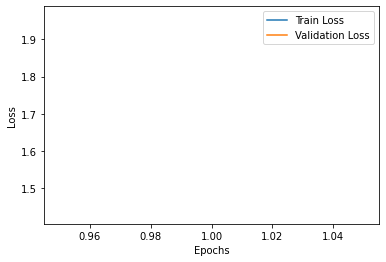

train loss:  0.471427493625217 iteration:  11000
train loss:  0.8495287895202637 iteration:  11500
train loss:  0.9384856657548384 iteration:  12000
train loss:  0.7178952066521895 iteration:  12500
train loss:  0.8230174912346734 iteration:  13000
train loss:  0.8263827641805013 iteration:  13500
train loss:  0.6303482670937816 iteration:  14000
train loss:  0.8257244213207348 iteration:  14500
train loss:  0.7421133677164714 iteration:  15000
train loss:  0.6203780770301819 iteration:  15500
train loss:  1.6235426197881284 iteration:  16000
train loss:  1.034210205078125 iteration:  16500
train loss:  0.5780145525932312 iteration:  17000
train loss:  0.8389235103831572 iteration:  17500
train loss:  1.864464569091797 iteration:  18000
train loss:  0.619677734375 iteration:  18500
train loss:  0.810830295085907 iteration:  19000
train loss:  3.1285618373325894 iteration:  19500
train loss:  0.8170345768784032 iteration:  20000
train loss:  1.1923246383666992 iteration:  20500
train lo

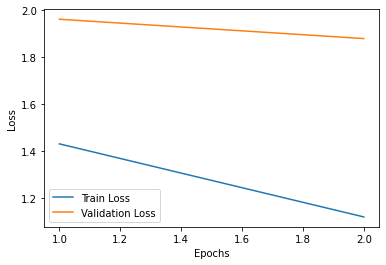

train loss:  0.31853732195767487 iteration:  21500
train loss:  0.7488258361816407 iteration:  22000
train loss:  0.7535555627610948 iteration:  22500
train loss:  3.3299654642740886 iteration:  23000
train loss:  0.787684440612793 iteration:  23500
train loss:  1.0912382419292743 iteration:  24000
train loss:  0.650555345747206 iteration:  24500
train loss:  0.5812007679658777 iteration:  25000
train loss:  0.6484850715188419 iteration:  25500
train loss:  1.186426321665446 iteration:  26000
train loss:  1.299253903902494 iteration:  26500
train loss:  1.7649580637613933 iteration:  27000
train loss:  1.0449500450721154 iteration:  27500
train loss:  0.8116063276926676 iteration:  28000
train loss:  1.1509841392780173 iteration:  28500
train loss:  0.8589668273925781 iteration:  29000
train loss:  0.4513664245605469 iteration:  29500
train loss:  0.16989239893461527 iteration:  30000
train loss:  1.3919891010631213 iteration:  30500
train loss:  0.834753365352236 iteration:  31000
tra

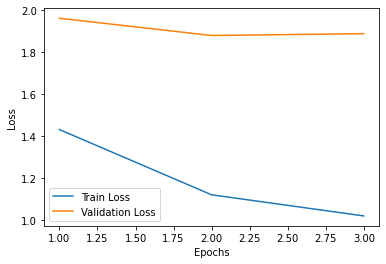

train loss:  1.660013198852539 iteration:  32500
train loss:  1.0523256000719572 iteration:  33000
train loss:  0.5826447168986003 iteration:  33500
train loss:  1.0082595189412435 iteration:  34000
train loss:  0.3901064925723606 iteration:  34500
train loss:  0.396381291476163 iteration:  35000
train loss:  0.5037349554208609 iteration:  35500
train loss:  1.6223943609940379 iteration:  36000
train loss:  3.042567084817325 iteration:  36500
train loss:  1.667502702985491 iteration:  37000
train loss:  0.5705227075621139 iteration:  37500
train loss:  1.8630971406635486 iteration:  38000
train loss:  0.3241058985392253 iteration:  38500
train loss:  0.27135554226962005 iteration:  39000
train loss:  0.4248591613769531 iteration:  39500
train loss:  1.5847156047821045 iteration:  40000
train loss:  0.8771568747127757 iteration:  40500
train loss:  0.43358403665048106 iteration:  41000
train loss:  3.345053932883523 iteration:  41500
train loss:  1.7024076307142102 iteration:  42000
tra

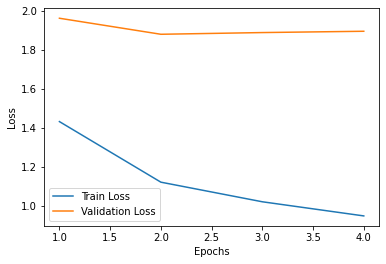

train loss:  0.5890257036363756 iteration:  43000
train loss:  0.5068623501321544 iteration:  43500
train loss:  0.3171695073445638 iteration:  44000
train loss:  0.7923805236816406 iteration:  44500
train loss:  0.17928288199684836 iteration:  45000
train loss:  0.279547780752182 iteration:  45500
train loss:  0.6995088643041151 iteration:  46000
train loss:  1.0363070487976074 iteration:  46500
train loss:  0.3707680557713364 iteration:  47000
train loss:  0.40439146757125854 iteration:  47500
train loss:  0.31387571334838865 iteration:  48000
train loss:  1.3885920489275898 iteration:  48500
train loss:  0.5108928150600858 iteration:  49000
train loss:  0.34810180134243435 iteration:  49500
train loss:  0.5509128009571749 iteration:  50000
train loss:  0.7445050115170686 iteration:  50500
train loss:  0.7444156010945638 iteration:  51000
train loss:  0.37350985583137064 iteration:  51500
train loss:  1.7074072911189153 iteration:  52000
train loss:  0.4029333716944644 iteration:  52

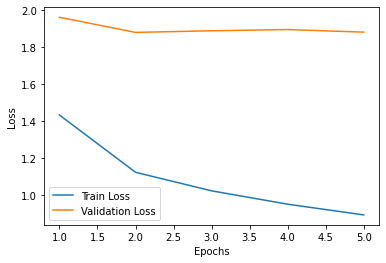

train eval: 
pred: CCCCCCCCCCCCcCcccccccccccccc)c)c)))))<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CCCccccccccccccccccccccccc)c)<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCCCCCCCCCCCcCcccccccccccccc)c)c)))))<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: COcccccc=O)oc6cc%10O<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCC)CCN=CO)C=O)cccccc6)))))))))C=O)O<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CCC)cccccccccccccccc))))))))))))))<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CCC)CCN=CO)C=O)cccccc6)))))))))C=O)O<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CCCccccccccccccccccccccccc)c)<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: COcccccc=O)oc6cc%10O<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCCccccccccccccccccccccccc)c)<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCCCCCCCCCCCcCcccccccccccccc)c)c)))))<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CCCccccccccccccccccccccccc)c)<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCCccccccccccccccccccccccc

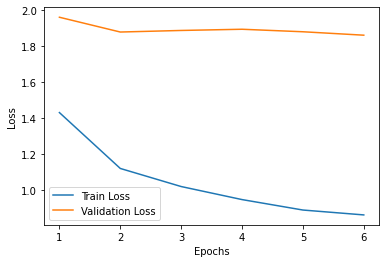

train loss:  0.3449183702468872 iteration:  64500
train loss:  0.5582494395119804 iteration:  65000
train loss:  0.5989980955381651 iteration:  65500
train loss:  0.36442710257865285 iteration:  66000
train loss:  1.2081030436924525 iteration:  66500
train loss:  1.5547327677408853 iteration:  67000
train loss:  1.1475601196289062 iteration:  67500
train loss:  0.45351899753917346 iteration:  68000
train loss:  0.6866675929019326 iteration:  68500
train loss:  2.247084140777588 iteration:  69000
train loss:  0.4032532374064128 iteration:  69500
train loss:  0.29129793984549385 iteration:  70000
train loss:  0.7543294770377023 iteration:  70500
train loss:  0.5104874058773643 iteration:  71000
train loss:  0.21524906158447266 iteration:  71500
train loss:  1.5835470541929588 iteration:  72000
train loss:  0.633843994140625 iteration:  72500
train loss:  1.4824026743570964 iteration:  73000
train loss:  1.4467239379882812 iteration:  73500
train loss:  0.4478162482932762 iteration:  7400

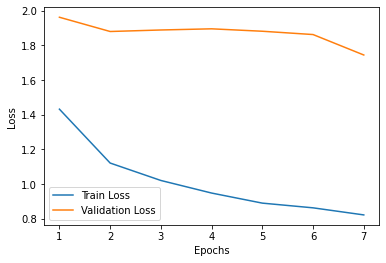

train loss:  0.425629395705003 iteration:  75000
train loss:  0.764509754796182 iteration:  75500
train loss:  0.30609496947257747 iteration:  76000
train loss:  0.5352602686200824 iteration:  76500
train loss:  0.22506876786549887 iteration:  77000
train loss:  0.3145022127363417 iteration:  77500
train loss:  0.5284470717112223 iteration:  78000
train loss:  0.296511173248291 iteration:  78500
train loss:  0.881605863571167 iteration:  79000
train loss:  0.37830744291606705 iteration:  79500
train loss:  1.5822475038725754 iteration:  80000
train loss:  0.19409416516621908 iteration:  80500
train loss:  0.5487428533619848 iteration:  81000
train loss:  0.6873728808234719 iteration:  81500
train loss:  0.3331073459826018 iteration:  82000
train loss:  0.31569693638728213 iteration:  82500
train loss:  0.4579370135352725 iteration:  83000
train loss:  0.8273117402020622 iteration:  83500
train loss:  0.2565008004506429 iteration:  84000
train loss:  0.821478613491716 iteration:  84500


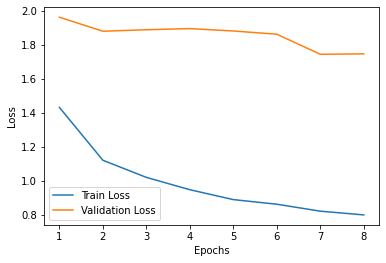

train loss:  0.9372898904900802 iteration:  85500
train loss:  0.2582962448532517 iteration:  86000
train loss:  0.3337627874838339 iteration:  86500
train loss:  0.4886107853480748 iteration:  87000
train loss:  2.1584284165326286 iteration:  87500
train loss:  0.17501559938703265 iteration:  88000
train loss:  0.3197315411689954 iteration:  88500
train loss:  1.308711543227687 iteration:  89000
train loss:  2.4573612213134766 iteration:  89500
train loss:  0.4478582259147398 iteration:  90000
train loss:  2.6325741818076684 iteration:  90500
train loss:  0.5683742761611938 iteration:  91000
train loss:  0.7717335224151611 iteration:  91500
train loss:  0.7013749016655816 iteration:  92000
train loss:  0.3163509884396115 iteration:  92500
train loss:  0.24028974260602678 iteration:  93000
train loss:  0.6517330408096313 iteration:  93500
train loss:  0.2298009055001395 iteration:  94000
train loss:  0.2133953143388797 iteration:  94500
train loss:  0.37453154155186247 iteration:  9500

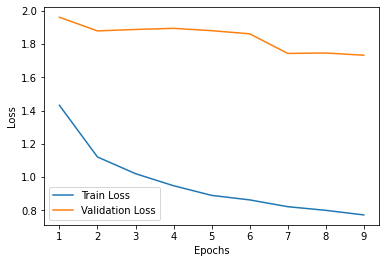

train loss:  0.24021818978445872 iteration:  96500
train loss:  1.0910963645348182 iteration:  97000
train loss:  0.4294155120849609 iteration:  97500
train loss:  0.21844406561418014 iteration:  98000
train loss:  0.6531394720077515 iteration:  98500
train loss:  0.6061617003546821 iteration:  99000
train loss:  0.4861420059204102 iteration:  99500
train loss:  1.0161233315101037 iteration:  100000
train loss:  0.5147258440653483 iteration:  100500
train loss:  1.9454022816249303 iteration:  101000
train loss:  0.9530536548511402 iteration:  101500
train loss:  1.482818001195004 iteration:  102000
train loss:  1.5824080074534697 iteration:  102500
train loss:  0.1766374188084756 iteration:  103000
train loss:  1.5516786193847656 iteration:  103500
train loss:  0.5451834777305866 iteration:  104000
train loss:  1.5973554669004497 iteration:  104500
train loss:  0.4415553092956543 iteration:  105000
train loss:  0.45918189154730904 iteration:  105500
train loss:  0.25667377312978107 ite

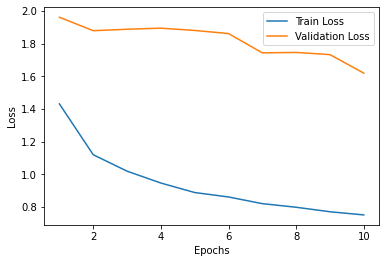

train eval: 
pred: CCC)NC=O)cccccc6N)))))))))))))CC)O<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: COccccccccccO)c)c<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCC)CCCCCcCcCcCCcC)Cc))))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CCC)CCCCCcCcCcCCcC)Cc))))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CCC)NC=O)cccccc6N)))))))))))))CC)O<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNCCCCC6cccccc6ccccccccccc))))))))))))<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: COccccccccccO)c)c<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCC)CCCCCcCcCcCCcC)Cc))))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CNCCCCC6cccccc6ccccccccccc))))))))))))<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCC)NC=O)cccccc6N)))))))))))))CC)O<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CCC)CCCCCcCcCcCCcC)Cc))))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COccccccccccO)c)c<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCC)CCCCCcCcCcCCcC)Cc)

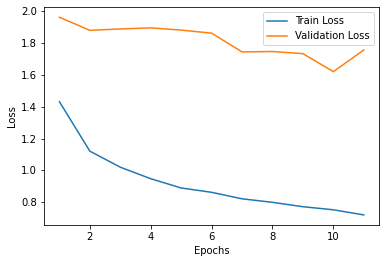

train loss:  0.4724983109368218 iteration:  118000
train loss:  3.1320053736368814 iteration:  118500
train loss:  0.31208971272344177 iteration:  119000
train loss:  0.3984368976793791 iteration:  119500
train loss:  0.47487758867668384 iteration:  120000
train loss:  1.62359619140625 iteration:  120500
train loss:  2.930981603162042 iteration:  121000
train loss:  0.2630802699497768 iteration:  121500
train loss:  1.6655122212001257 iteration:  122000
train loss:  0.8103934288024902 iteration:  122500
train loss:  0.15147245497930617 iteration:  123000
train loss:  0.3280150776817685 iteration:  123500
train loss:  0.4081946849822998 iteration:  124000
train loss:  0.248138794532189 iteration:  124500
train loss:  0.18218320124858134 iteration:  125000
train loss:  0.18259028465517105 iteration:  125500
train loss:  3.0377589634486606 iteration:  126000
train loss:  1.4686710834503174 iteration:  126500
train loss:  0.20453508969010978 iteration:  127000
train loss:  0.28244919247097

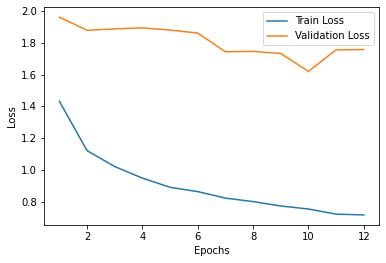

train loss:  1.5768349106247361 iteration:  128500
train loss:  0.2146475531838157 iteration:  129000
train loss:  0.9378980439284752 iteration:  129500
train loss:  2.97157444673426 iteration:  130000
train loss:  2.9980013166155133 iteration:  130500
train loss:  1.9338503870470771 iteration:  131000
train loss:  0.49689226150512694 iteration:  131500
train loss:  0.4362255622600687 iteration:  132000
train loss:  0.3782665589276482 iteration:  132500
train loss:  0.3975018819173177 iteration:  133000
train loss:  0.19868132803175184 iteration:  133500
train loss:  2.4144692256532867 iteration:  134000
train loss:  0.27676722877903986 iteration:  134500
train loss:  1.9543471336364746 iteration:  135000
train loss:  0.38502379386655744 iteration:  135500
train loss:  0.6435733068557012 iteration:  136000
train loss:  0.3134373982747396 iteration:  136500
train loss:  0.2451416065818385 iteration:  137000
train loss:  2.111255168914795 iteration:  137500
train loss:  0.302085600401225

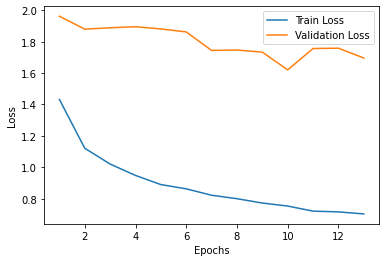

train loss:  0.34280656632922946 iteration:  139000
train loss:  2.867505303744612 iteration:  139500
train loss:  0.37024080753326416 iteration:  140000
train loss:  0.5976202011108398 iteration:  140500
train loss:  0.5356716933073821 iteration:  141000
train loss:  0.16904894872145218 iteration:  141500
train loss:  0.28633115098283096 iteration:  142000
train loss:  0.3812738882528769 iteration:  142500
train loss:  0.973204444436466 iteration:  143000
train loss:  0.3863876433599563 iteration:  143500
train loss:  0.49431767463684084 iteration:  144000
train loss:  0.28974530696868894 iteration:  144500
train loss:  0.9733355595515325 iteration:  145000
train loss:  0.30702144077845983 iteration:  145500
train loss:  0.2181030323630885 iteration:  146000
train loss:  1.6350989165129486 iteration:  146500
train loss:  0.4932448738499692 iteration:  147000
train loss:  0.3378029266993205 iteration:  147500
train loss:  0.6998978115263439 iteration:  148000
train loss:  0.23359233682

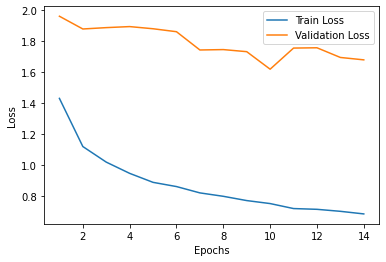

train loss:  0.26609616666226776 iteration:  150000
train loss:  0.23832829793294272 iteration:  150500
train loss:  0.2112940788269043 iteration:  151000
train loss:  0.23450059049269734 iteration:  151500
train loss:  2.0423985649557674 iteration:  152000
train loss:  0.21979057788848877 iteration:  152500
train loss:  0.1729909062385559 iteration:  153000
train loss:  0.5648764830369216 iteration:  153500
train loss:  0.19952668314394745 iteration:  154000
train loss:  0.24870611639583812 iteration:  154500
train loss:  0.5023568960336539 iteration:  155000
train loss:  0.309415790769789 iteration:  155500
train loss:  0.18555452949122378 iteration:  156000
train loss:  0.7514936740581806 iteration:  156500
train loss:  0.4119570115033318 iteration:  157000
train loss:  0.4967918395996094 iteration:  157500
train loss:  4.125573244961825 iteration:  158000
train loss:  0.29576041247393636 iteration:  158500
train loss:  1.4599859574261833 iteration:  159000
train loss:  0.2120741367

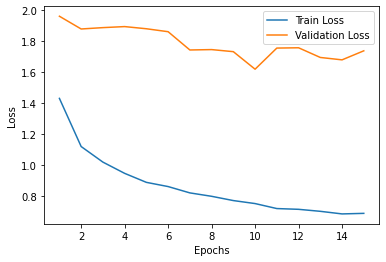

train eval: 
pred: CCCcCccccccccccccccc))))))))))))<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: COcccccc6OCOCCO))C)))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COcccccC=O)O))c6c<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCCcCccccccccccccccc))))))))))))<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: COcccccc6OCOCCO))C)))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COcccccC=O)O))c6c<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCCccccccccccc))))))))))))))))))))))O<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CCC)CN=CO)Ccc[nH]ccccccc96))))))))))))CC6<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CCCccccccccccc))))))))))))))))))))))O<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CCCcCccccccccccccccc))))))))))))<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCCccccccccccc))))))))))))))))))))))O<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CCCccccccccccc))))))))))))))))))))))O<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CCC)CN=CO)Ccc[nH]cccccc

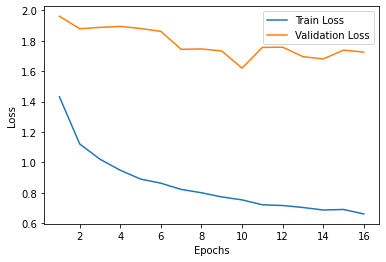

train loss:  1.6772851686219912 iteration:  171000
train loss:  0.6060254496912802 iteration:  171500
train loss:  0.29807465417044504 iteration:  172000
train loss:  0.15121967652264764 iteration:  172500
train loss:  0.46871604919433596 iteration:  173000
train loss:  2.359076436360677 iteration:  173500
train loss:  0.28223406883978075 iteration:  174000
train loss:  0.3509804985739968 iteration:  174500
train loss:  0.4016882578531901 iteration:  175000
train loss:  0.3790072250366211 iteration:  175500
train loss:  0.46096229553222656 iteration:  176000
train loss:  0.22737981291378245 iteration:  176500
train loss:  0.15758705139160156 iteration:  177000
train loss:  0.2099059820175171 iteration:  177500
train loss:  2.3088090079171315 iteration:  178000
train loss:  0.2781778150989163 iteration:  178500
train loss:  0.3179994159274631 iteration:  179000
train loss:  0.19869644939899445 iteration:  179500
train loss:  0.21801512057964617 iteration:  180000
train loss:  0.21898466

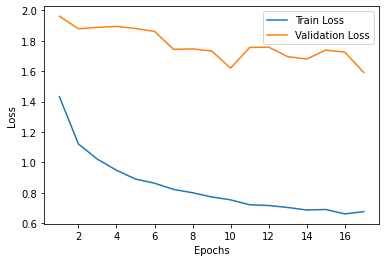

train loss:  0.11124656200408936 iteration:  182000
train loss:  0.26750189607793634 iteration:  182500
train loss:  0.1680726882738945 iteration:  183000
train loss:  0.859897180037065 iteration:  183500
train loss:  0.37741653124491376 iteration:  184000
train loss:  0.17015878720716995 iteration:  184500
train loss:  0.43751105140237245 iteration:  185000
train loss:  0.2969900767008464 iteration:  185500
train loss:  0.7565230051676433 iteration:  186000
train loss:  0.1759102256209762 iteration:  186500
train loss:  0.532823793815844 iteration:  187000
train loss:  0.6844472885131836 iteration:  187500
train loss:  0.21804657497921506 iteration:  188000
train loss:  0.5736376109876131 iteration:  188500
train loss:  0.16617686608258417 iteration:  189000
train loss:  1.578142108339252 iteration:  189500
train loss:  0.12676117636940695 iteration:  190000
train loss:  0.3921760212291371 iteration:  190500
train loss:  0.15636073975335985 iteration:  191000
train loss:  0.1863343654

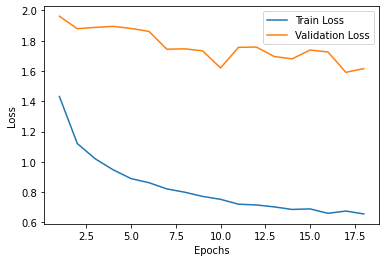

train loss:  0.14876190821329752 iteration:  192500
train loss:  0.19520718710763113 iteration:  193000
train loss:  0.470500389734904 iteration:  193500
train loss:  0.14332201367332822 iteration:  194000
train loss:  0.2528075610890108 iteration:  194500
train loss:  0.13494272459120976 iteration:  195000
train loss:  0.3667304412178371 iteration:  195500
train loss:  0.18798562807914537 iteration:  196000
train loss:  1.7846626705593533 iteration:  196500
train loss:  0.11243190084184919 iteration:  197000
train loss:  0.9200643999823208 iteration:  197500
train loss:  0.14888907614208402 iteration:  198000
train loss:  0.2730037184322582 iteration:  198500
train loss:  0.2737878741640033 iteration:  199000
train loss:  0.30607142655745795 iteration:  199500
train loss:  0.34668617248535155 iteration:  200000
train loss:  0.5773900349934896 iteration:  200500
train loss:  2.9772628784179687 iteration:  201000
train loss:  0.1246888796488444 iteration:  201500
train loss:  1.46744145

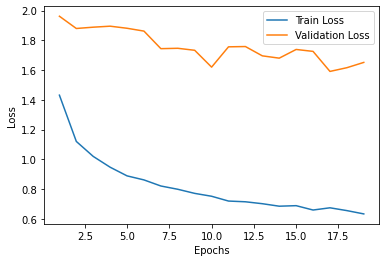

train loss:  3.3701385498046874 iteration:  203000
train loss:  0.14186758995056153 iteration:  203500
train loss:  0.16607171013241723 iteration:  204000
train loss:  1.2927667829725478 iteration:  204500
train loss:  0.15049784111254144 iteration:  205000
train loss:  0.24097532384535847 iteration:  205500
train loss:  0.21185616084507533 iteration:  206000
train loss:  0.5437327067057292 iteration:  206500
train loss:  0.07592833403385046 iteration:  207000
train loss:  0.30936917136697206 iteration:  207500
train loss:  0.6634646329012784 iteration:  208000
train loss:  0.05302264624171787 iteration:  208500
train loss:  0.1884784357888358 iteration:  209000
train loss:  0.18134231825132627 iteration:  209500
train loss:  0.2397634188334147 iteration:  210000
train loss:  0.28376509692217855 iteration:  210500
train loss:  0.23796380890740287 iteration:  211000
train loss:  0.08806478977203369 iteration:  211500
train loss:  0.1500846227010091 iteration:  212000
train loss:  0.2085

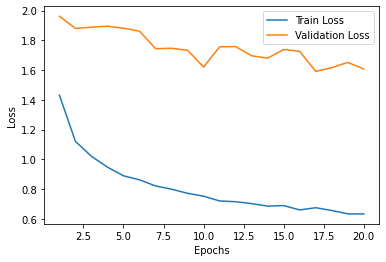

train eval: 
pred: COcccccc6C=CC=O)O<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCC)Nccccncccccc)))))))))))))))))<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNCCCccccccccccccccccccc)ccc)))))<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CNCCCNcnccO)cccccccccccccccccc69<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CCC)Nccccncccccc)))))))))))))))))<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNCCCNcnccO)cccccccccccccccccc69<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: COcccccc6OCCO)C=CCCC%11)NC)CCC%13%106<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CCC)Nccccncccccc)))))))))))))))))<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: COcccccc6OCCO)C=CCCC%11)NC)CCC%13%106<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COcccccc6OCCO)C=CCCC%11)NC)CCC%13%106<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COcccccc6OCCO)C=CCCC%11)NC)CCC%13%106<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CNCCCccccccccccccccccccc)ccc)))))<EOS>
real: cccccc

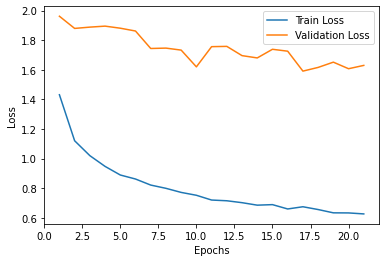

train loss:  0.321196585893631 iteration:  224500
train loss:  0.35691228594098773 iteration:  225000
train loss:  1.602096108829274 iteration:  225500
train loss:  0.18665165219988142 iteration:  226000
train loss:  3.5630470558449074 iteration:  226500
train loss:  1.3483556600717397 iteration:  227000
train loss:  0.3765251086308406 iteration:  227500
train loss:  0.28262682883970197 iteration:  228000
train loss:  0.26780845642089846 iteration:  228500
train loss:  0.2747460774012974 iteration:  229000
train loss:  0.2659815549850464 iteration:  229500
train loss:  0.3930132627487183 iteration:  230000
train loss:  0.1679033660888672 iteration:  230500
train loss:  0.2847949266433716 iteration:  231000
train loss:  2.363036415793679 iteration:  231500
train loss:  0.17896195558401254 iteration:  232000
train loss:  0.2564140488119686 iteration:  232500
train loss:  0.2804800934261746 iteration:  233000
train loss:  2.899178476044626 iteration:  233500
train loss:  0.068731479346752

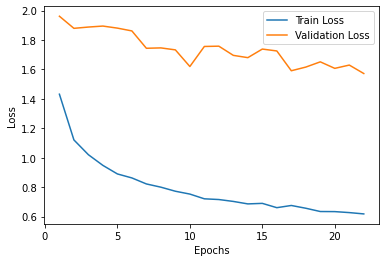

train loss:  0.9477746269919656 iteration:  235500
train loss:  0.10229874820244021 iteration:  236000
train loss:  0.19899077569284745 iteration:  236500
train loss:  0.15583495299021402 iteration:  237000
train loss:  0.16189770698547362 iteration:  237500
train loss:  1.3645498376143606 iteration:  238000
train loss:  0.20387063528362073 iteration:  238500
train loss:  0.18508944246504042 iteration:  239000
train loss:  0.2261997919816237 iteration:  239500
train loss:  0.22788355900691107 iteration:  240000
train loss:  1.5429152382744684 iteration:  240500
train loss:  0.19169650475184122 iteration:  241000
train loss:  0.17580261983369527 iteration:  241500
train loss:  1.0474015512774069 iteration:  242000
train loss:  0.34126244272504536 iteration:  242500
train loss:  0.29979681968688965 iteration:  243000
train loss:  0.2645256940056296 iteration:  243500
train loss:  0.27788984775543213 iteration:  244000
train loss:  0.22011175155639648 iteration:  244500
train loss:  0.358

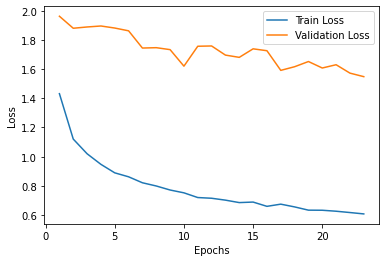

train loss:  0.31783218383789064 iteration:  246000
train loss:  0.08884288370609283 iteration:  246500
train loss:  1.4827924267999057 iteration:  247000
train loss:  2.1523673717792215 iteration:  247500
train loss:  2.663263887972445 iteration:  248000
train loss:  0.2740286863767184 iteration:  248500
train loss:  0.08373756666441222 iteration:  249000
train loss:  0.3376038800115171 iteration:  249500
train loss:  0.2901735578264509 iteration:  250000
train loss:  0.3685314758964207 iteration:  250500
train loss:  0.14966540109543575 iteration:  251000
train loss:  0.2878461920696756 iteration:  251500
train loss:  1.5893711362566267 iteration:  252000
train loss:  0.16582905054092406 iteration:  252500
train loss:  0.19439064372669568 iteration:  253000
train loss:  1.8419596354166667 iteration:  253500
train loss:  1.4725538889567058 iteration:  254000
train loss:  0.15208820501963297 iteration:  254500
train loss:  0.2350403219461441 iteration:  255000
train loss:  0.1603279943

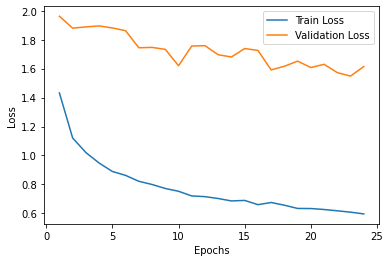

train loss:  0.2283803621927897 iteration:  256500
train loss:  0.09130544197268603 iteration:  257000
train loss:  0.4951190494355701 iteration:  257500
train loss:  0.16096845166436557 iteration:  258000
train loss:  0.1183055771721734 iteration:  258500
train loss:  0.3946329355239868 iteration:  259000
train loss:  0.23155222833156586 iteration:  259500
train loss:  0.4189312878776999 iteration:  260000
train loss:  1.112821674346924 iteration:  260500
train loss:  0.7341330268166282 iteration:  261000
train loss:  1.5232584553380166 iteration:  261500
train loss:  0.14165806770324707 iteration:  262000
train loss:  0.21949197695805475 iteration:  262500
train loss:  1.3523880396133814 iteration:  263000
train loss:  0.14212136655240445 iteration:  263500
train loss:  0.1348634123802185 iteration:  264000
train loss:  0.5452816907097312 iteration:  264500
train loss:  0.270258623010972 iteration:  265000
train loss:  0.08978626841590517 iteration:  265500
train loss:  0.15667867660

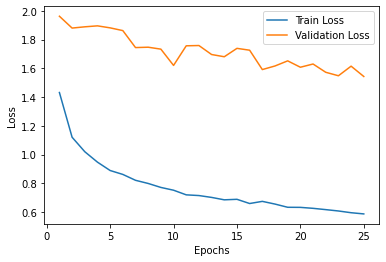

train eval: 
pred: COcccC=CC=O))))ccc6O<EOS>
real: COcccccC=CC=O)O))))c6
pred: CNCCCcccccc6))))))cccccn6)))))))CC6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCCCCCNCCccCcCcccccccccc)))))))))))))))<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: COccccCcccccccccc))))))))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COccccCcccccccccc))))))))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CCCCCCNCCccCcCcccccccccc)))))))))))))))<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CNCCCcccccc6))))))cccccn6)))))))CC6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CNCCCcccccc6))))))cccccn6)))))))CC6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCCSccccncN=CO)OC))))[nH]c5c9<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CCCSccccncN=CO)OC))))[nH]c5c9<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNCCCcccccc6))))))cccccn6)))))))CC6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCCSccccncN=CO)OC))))[nH]c5c9<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: 

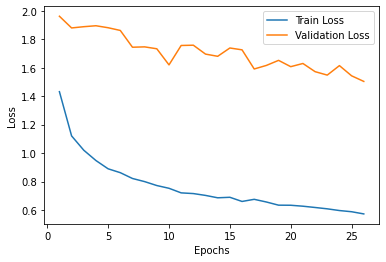

train loss:  0.2612324494581956 iteration:  278000
train loss:  0.3609010696411133 iteration:  278500
train loss:  0.8940540762508616 iteration:  279000
train loss:  2.1572440894874365 iteration:  279500
train loss:  0.3241267204284668 iteration:  280000
train loss:  0.19321133693059286 iteration:  280500
train loss:  0.11955945115340383 iteration:  281000
train loss:  0.2059742742114597 iteration:  281500
train loss:  0.2993382385798863 iteration:  282000
train loss:  0.47768598132663304 iteration:  282500
train loss:  0.23638514110020228 iteration:  283000
train loss:  0.18166898091634115 iteration:  283500
train loss:  0.13568982124328613 iteration:  284000
train loss:  2.0626118567682084 iteration:  284500
train loss:  0.08515309625201756 iteration:  285000
train loss:  1.0963010480326991 iteration:  285500
train loss:  0.33650959455049956 iteration:  286000
train loss:  0.2817687392234802 iteration:  286500
train loss:  0.08678832179621647 iteration:  287000
train loss:  2.0972361

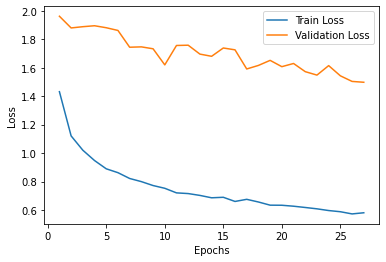

train loss:  2.254352060953776 iteration:  288500
train loss:  2.5196011517498946 iteration:  289000
train loss:  2.7034170968191966 iteration:  289500
train loss:  0.26888769323175604 iteration:  290000
train loss:  0.1923758145925161 iteration:  290500
train loss:  0.11712264060974122 iteration:  291000
train loss:  0.08624253008100721 iteration:  291500
train loss:  2.4078983306884765 iteration:  292000
train loss:  0.2123303254445394 iteration:  292500
train loss:  0.28818368911743164 iteration:  293000
train loss:  0.13668434619903563 iteration:  293500
train loss:  0.22680263519287108 iteration:  294000
train loss:  0.12075790115024733 iteration:  294500
train loss:  0.13927902494158065 iteration:  295000
train loss:  0.5447141102382115 iteration:  295500
train loss:  0.40977704524993896 iteration:  296000
train loss:  0.8712869057288537 iteration:  296500
train loss:  0.3330941427321661 iteration:  297000
train loss:  0.0640677081214057 iteration:  297500
train loss:  1.45809364

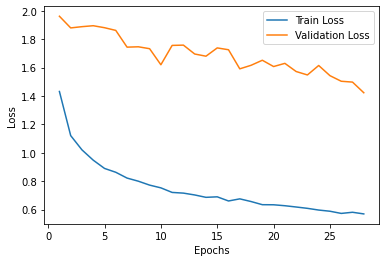

train loss:  0.1540240112103914 iteration:  299500
train loss:  0.15294434229532877 iteration:  300000
train loss:  2.709035520200376 iteration:  300500
train loss:  0.07297017839219835 iteration:  301000
train loss:  0.12841251734140757 iteration:  301500
train loss:  0.28523050035749165 iteration:  302000
train loss:  0.18438024874086734 iteration:  302500
train loss:  0.11634895536634657 iteration:  303000
train loss:  1.5515562969705332 iteration:  303500
train loss:  0.34123730659484863 iteration:  304000
train loss:  1.1157641044029822 iteration:  304500
train loss:  0.1824610934538 iteration:  305000
train loss:  0.2908206447478264 iteration:  305500
train loss:  0.30075645446777344 iteration:  306000
train loss:  0.14026297944964786 iteration:  306500
train loss:  0.14296653193812217 iteration:  307000
train loss:  0.12199518008109851 iteration:  307500
train loss:  0.42185753042047675 iteration:  308000
train loss:  0.5351171860328088 iteration:  308500
train loss:  0.23714322

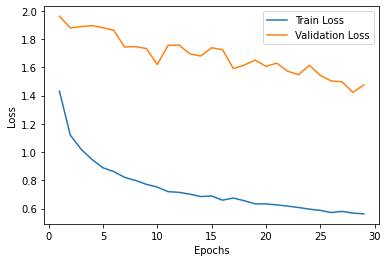

train loss:  0.28536608724883106 iteration:  310000
train loss:  0.042220118972990245 iteration:  310500
train loss:  0.08027468787299262 iteration:  311000
train loss:  0.2512833100778085 iteration:  311500
train loss:  0.16896132230758668 iteration:  312000
train loss:  0.13686309541974748 iteration:  312500
train loss:  0.30523436410086496 iteration:  313000
train loss:  0.2425856223473182 iteration:  313500
train loss:  0.4348011414210002 iteration:  314000
train loss:  0.1892376078499688 iteration:  314500
train loss:  0.19264609473092215 iteration:  315000
train loss:  0.11124361188788164 iteration:  315500
train loss:  0.39813269509209526 iteration:  316000
train loss:  0.2198244833177136 iteration:  316500
train loss:  0.34527732849121096 iteration:  317000
train loss:  0.11881773612078499 iteration:  317500
train loss:  0.31827047892979216 iteration:  318000
train loss:  0.47022608052129333 iteration:  318500
train loss:  0.11123644828796386 iteration:  319000
train loss:  2.6

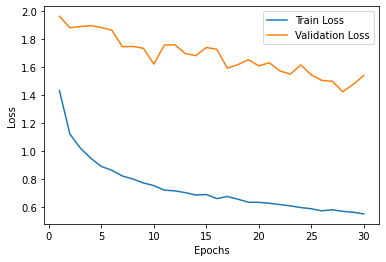

train eval: 
pred: CNCCCcccccc6))))))cccccn6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CNCCCcccccc6))))))cccccn6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CNCCCcccccc6))))))cccccn6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CCCSccccncN=CO)OC))))[nH]c5c9<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNCCCcccccc6))))))cccccn6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: COcccccC=CC=O)O))))c6<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCCSccccncN=CO)OC))))[nH]c5c9<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNCCCNccC)C)Cccccccccccc)))))))))))))CC<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CNCCCcccccc6))))))cccccn6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CNCCCC5CCOC=O)CO)cccccc6)))))))))C7<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CCCSccccncN=CO)OC))))[nH]c5c9<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNCCCcccccc6))))))cccccn6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CNCCCcccccc6))))))cccccn6<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CNCCCC5CCOC=O)

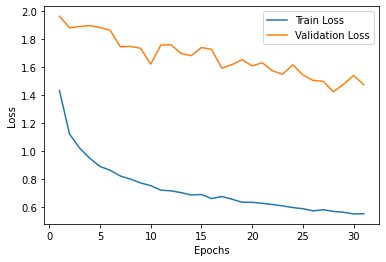

train loss:  0.15273582935333252 iteration:  331500
train loss:  0.1520104100627284 iteration:  332000
train loss:  0.2010064675257756 iteration:  332500
train loss:  0.4521241505940755 iteration:  333000
train loss:  0.07289151350657146 iteration:  333500
train loss:  0.22542236328125 iteration:  334000
train loss:  0.19747377324987342 iteration:  334500
train loss:  0.5069962607489692 iteration:  335000
train loss:  1.5110708618164062 iteration:  335500
train loss:  0.22689874031964472 iteration:  336000
train loss:  0.3849086420876639 iteration:  336500
train loss:  0.45262649324205184 iteration:  337000
train loss:  0.8083495563930936 iteration:  337500
train loss:  0.027388082100794867 iteration:  338000
train loss:  2.2646212577819824 iteration:  338500
train loss:  0.22967114559439725 iteration:  339000
train loss:  1.6422938178567326 iteration:  339500
train loss:  0.1321639929498945 iteration:  340000
train loss:  0.1661024789015452 iteration:  340500
train loss:  0.2332474142

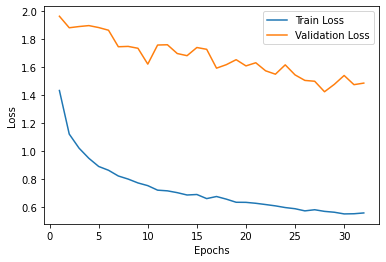

train loss:  0.18157128131750858 iteration:  342000
train loss:  0.3842275381088257 iteration:  342500
train loss:  0.2878162210637873 iteration:  343000
train loss:  0.18891341156429714 iteration:  343500
train loss:  2.392571767171224 iteration:  344000
train loss:  3.008514404296875 iteration:  344500
train loss:  1.299287022771062 iteration:  345000
train loss:  0.1012368852441961 iteration:  345500
train loss:  2.784977408016429 iteration:  346000
train loss:  0.09505079388618469 iteration:  346500
train loss:  0.21187408447265624 iteration:  347000
train loss:  0.46366636376631887 iteration:  347500
train loss:  0.13541241253123565 iteration:  348000
train loss:  2.3920669555664062 iteration:  348500
train loss:  1.5570040616122158 iteration:  349000
train loss:  0.19927402337392172 iteration:  349500
train loss:  0.25103145837783813 iteration:  350000
train loss:  0.2311178594827652 iteration:  350500
train loss:  0.15907626152038573 iteration:  351000
train loss:  3.12459668246

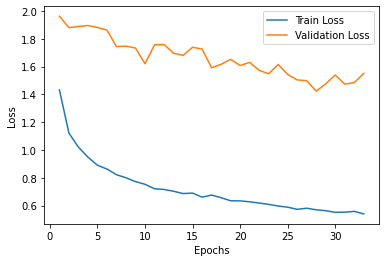

train loss:  0.24202697030429182 iteration:  353000
train loss:  1.6506913503011067 iteration:  353500
train loss:  0.37029920622359874 iteration:  354000
train loss:  0.17300011052025688 iteration:  354500
train loss:  2.1225964090098506 iteration:  355000
train loss:  0.4632984074679288 iteration:  355500
train loss:  0.8549710909525553 iteration:  356000
train loss:  0.35471623284476145 iteration:  356500
train loss:  1.7039082845052083 iteration:  357000
train loss:  4.022305032481318 iteration:  357500
train loss:  0.12142855387467605 iteration:  358000
train loss:  0.3066947221755981 iteration:  358500
train loss:  0.15181831518809 iteration:  359000
train loss:  0.20754620688302175 iteration:  359500
train loss:  2.274165047539605 iteration:  360000
train loss:  1.4706552028656006 iteration:  360500
train loss:  0.14958919178355823 iteration:  361000
train loss:  0.04276740550994873 iteration:  361500
train loss:  0.17696940898895264 iteration:  362000
train loss:  2.14952289356

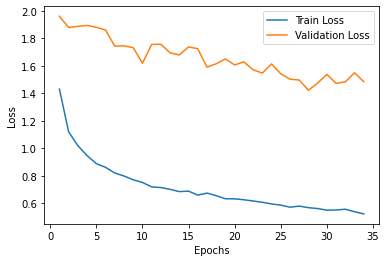

train loss:  0.3537317216396332 iteration:  363500
train loss:  0.11806784976612437 iteration:  364000
train loss:  0.18329393296014695 iteration:  364500
train loss:  0.25865582057407926 iteration:  365000
train loss:  0.5580320358276367 iteration:  365500
train loss:  0.09716296195983887 iteration:  366000
train loss:  0.2788587510585785 iteration:  366500
train loss:  0.18071261644363404 iteration:  367000
train loss:  0.12565204405015515 iteration:  367500
train loss:  0.2382506957420936 iteration:  368000
train loss:  0.11606216430664062 iteration:  368500
train loss:  0.5305257336846714 iteration:  369000
train loss:  1.245537312825521 iteration:  369500
train loss:  0.14205115880721655 iteration:  370000
train loss:  0.28852417355492 iteration:  370500
train loss:  0.18879144841974432 iteration:  371000
train loss:  0.15712525393511798 iteration:  371500
train loss:  2.1323033287411643 iteration:  372000
train loss:  1.1675025939941406 iteration:  372500
train loss:  0.237983202

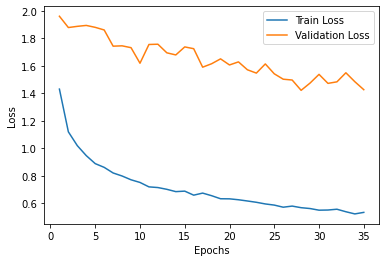

train eval: 
pred: CNCCCNCCC6CC6CO)ccccncccccccccccc<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CNCCCNCCC6CC6CO)ccccncccccccccccc<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CNCCCC5CCccccO)cc6cCC))))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CNCCCC5CCccccO)cc6cCC))))))))))))))<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COcccccC=CC=O)O))<EOS>
real: COcccccC=CC=O)O))))c6
pred: CNCCCNCCC6CC6CO)ccccncccccccccccc<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: CCCSccccncN=CO)OC))))[nH]c5c9<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNCCCcccccc6cccccccccc))))))))<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: COcccccC=CC=O)O))<EOS>
real: COcccccC=CC=O)O))))c6
pred: COcccccC=CC=O)O))<EOS>
real: COcccccC=CC=O)O))))c6
pred: COcccccC=CC=O)O))<EOS>
real: COcccccC=CC=O)O))))c6
pred: CNCCCcccccc6cccccccccc))))))))<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: CNCCCNCCC6CC6CO)ccccncccccccccccc<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred

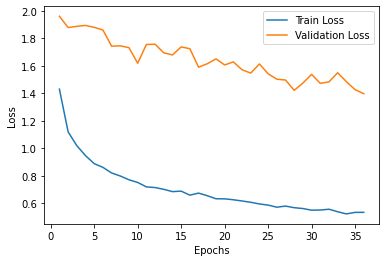

train loss:  0.1431530475616455 iteration:  385000
train loss:  0.3148610591888428 iteration:  385500
train loss:  2.029463359287807 iteration:  386000
train loss:  0.155329835825953 iteration:  386500
train loss:  0.1878634520939418 iteration:  387000
train loss:  0.18399089813232422 iteration:  387500
train loss:  0.3071560366400357 iteration:  388000
train loss:  6.9141286214192705 iteration:  388500
train loss:  0.29830071505378275 iteration:  389000
train loss:  0.34243111610412597 iteration:  389500
train loss:  0.038189007685734674 iteration:  390000
train loss:  1.9792582194010417 iteration:  390500
train loss:  0.19659184084998238 iteration:  391000
train loss:  0.1036196368081229 iteration:  391500
train loss:  0.28762161440965606 iteration:  392000
train loss:  0.05919464429219564 iteration:  392500
train loss:  0.10376401080025567 iteration:  393000
train loss:  1.9809174170860877 iteration:  393500
train loss:  0.14781475067138672 iteration:  394000
train loss:  0.22112151

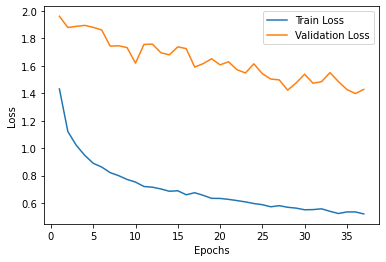

train loss:  0.08765217505003277 iteration:  395500
train loss:  0.0886317321232387 iteration:  396000
train loss:  0.2302510897318522 iteration:  396500
train loss:  0.08203851735150372 iteration:  397000
train loss:  0.21652046839396158 iteration:  397500
train loss:  0.11809619267781575 iteration:  398000
train loss:  0.03449594974517822 iteration:  398500
train loss:  0.17291328112284343 iteration:  399000
train loss:  1.708589744567871 iteration:  399500
train loss:  0.13472113155183338 iteration:  400000
train loss:  0.2408541188095555 iteration:  400500
train loss:  0.14528456101050743 iteration:  401000
train loss:  0.22983219226201376 iteration:  401500
train loss:  0.22494308948516845 iteration:  402000
train loss:  0.2207364378304317 iteration:  402500
train loss:  0.2503646305629185 iteration:  403000
train loss:  0.09048263971195665 iteration:  403500
train loss:  0.05588262610965305 iteration:  404000
train loss:  0.10351841377489494 iteration:  404500
train loss:  2.3029

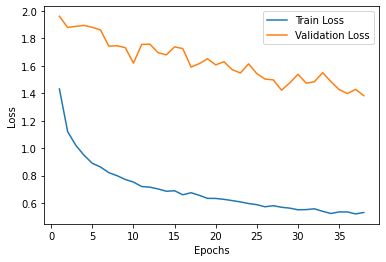

train loss:  0.28956047058105466 iteration:  406000
train loss:  0.037820787806259956 iteration:  406500
train loss:  0.1784268569946289 iteration:  407000
train loss:  0.14698447900659897 iteration:  407500
train loss:  0.13061952590942383 iteration:  408000
train loss:  0.21325111389160156 iteration:  408500
train loss:  0.23216552734375 iteration:  409000
train loss:  0.2598867893218994 iteration:  409500
train loss:  1.69647159576416 iteration:  410000
train loss:  1.8747944150652205 iteration:  410500
train loss:  0.25910282135009766 iteration:  411000
train loss:  0.23470108849661692 iteration:  411500
train loss:  0.3326693159161192 iteration:  412000
train loss:  1.4685792105538504 iteration:  412500
train loss:  0.2691111998124556 iteration:  413000
train loss:  0.060207342279368435 iteration:  413500
train loss:  0.14310831824938455 iteration:  414000
train loss:  0.3172208101321489 iteration:  414500
train loss:  2.806060188695004 iteration:  415000
train loss:  0.4976552327

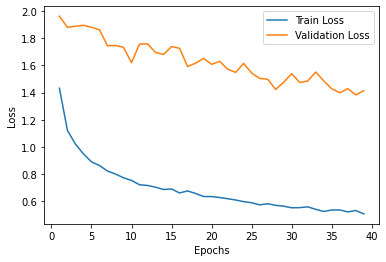

train loss:  0.08295302391052246 iteration:  417000
train loss:  1.7079254676555764 iteration:  417500
train loss:  0.1532563809995298 iteration:  418000
train loss:  0.1135438060760498 iteration:  418500
train loss:  0.27891388645878545 iteration:  419000
train loss:  0.1492141210115873 iteration:  419500
train loss:  0.3189202626546224 iteration:  420000
train loss:  0.1822032928466797 iteration:  420500
train loss:  0.0635477602481842 iteration:  421000
train loss:  0.07146724901701275 iteration:  421500
train loss:  2.1924733055962458 iteration:  422000
train loss:  0.17161941528320312 iteration:  422500
train loss:  0.2770870159833859 iteration:  423000
train loss:  0.2734142541885376 iteration:  423500
train loss:  0.4965210327735314 iteration:  424000
train loss:  0.17256550166917883 iteration:  424500
train loss:  2.837291115208676 iteration:  425000
train loss:  2.815377900094697 iteration:  425500
train loss:  0.10353207588195801 iteration:  426000
train loss:  0.193448488528

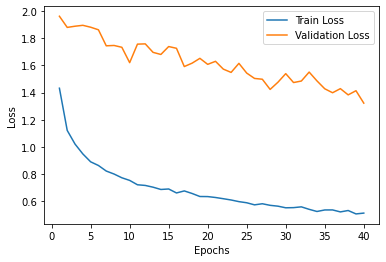

train eval: 
pred: CNCCCC5CC=O)O))COC=O)cccccc6))))))))C7<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CNCCCC5CC=O)O))COC=O)cccccc6))))))))C7<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: CNCCCccccccccccc)cc)c)))cccc<EOS>
real: cccccc6)Ccccccc6NCCNCC%156
pred: COcccccC=CC=O)O))))c6<EOS>
real: COcccccC=CC=O)O))))c6
pred: CNCCCC5CC=O)O))COC=O)cccccc6))))))))C7<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COcccccC=CC=O)O))))c6<EOS>
real: COcccccC=CC=O)O))))c6
pred: COcccccC=CC=O)O))))c6<EOS>
real: COcccccC=CC=O)O))))c6
pred: CCCSccccncN=CO)OC))))[nH]c5c9<EOS>
real: CCCSccccncN=CO)OC))))[nH]c5c9
pred: CNC)CCN=CO)C=Ccccccc6))))))cccccc6<EOS>
real: CC=CCNCCC6CCO))C6Ccc8[nH]cccccc96
pred: COcccccC=CC=O)O))))c6<EOS>
real: COcccccC=CC=O)O))))c6
pred: CNCCCC5CC=O)O))COC=O)cccccc6))))))))C7<EOS>
real: O=CC=CC=Ccccccc6)OCO5))))))))))))NCCCCC6
pred: COcccccC=CC=O)O))))c6<EOS>
real: COcccccC=CC=O)O))))c6
pred: CNCCCC5CC=O)O))COC=O)cccccc6))))))))C7<EOS>
real: O=

In [45]:
model_function()